**Pytorch Image Classification using Sagemaker**

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.
This project is designed for you to show your skills in applying Pytorch/Keras for image classification using sagemaker.
You should do some hyperparameter tuning jobs, and use sagemaker debugger to show how your model fit in the best way and how are you improve or stopped during fitting a pretrained model like Resnet50. You should also use sagemaker profiler to show how you are using resources like cpu and gpu during model fitting.

You should do the following jobs to successfully pass the project:

    1. Download a favorite dataset like Dogbreeds (which contains images of 133 dog breeds.)
    2. Read the dataset and do some preprocessing jobs on its images if necessary. 
    caution: You should be carefull about this point that all the datasets don't have a normal sized images e.g. Dogbreeds dataset does not have images all in the same size. So you should do some transform jobs whenever you need. 
    3.Feed your dataset to a chosen pre-trained model (e.g. Resnet50), by using a kind of estimator and also fine tune the model using HyperparameterTuner.
    4. Fit your HyperparameterTuner! Remember to include your data channels. 
    5. Get the best hyperparameters to start fine tuning the model. At this stage also include the sagemaker profiler and debugger to supervise your model training.
    6. Plot some features like losses you catched from the training/evalidating process using hook.
    7. Plot the time series of your profiler.
    8. Create an endpoint of your model predictor. 
    8. Deploy the predictor to some sample data and print the results.

In [75]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install torchvision --no-cache-dir
!pip install torch --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils 

In [76]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import argparse
import pathlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np
from sagemaker.pytorch import PyTorch  # PyTorch Estimator for TensorFlow
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [6]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-01-25 10:17:54--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.117.16
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.117.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  15.2MB/s    in 92s     

2022-01-25 10:19:27 (11.7 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [43]:
!ls dogImages

test  train  valid


In [44]:
!ls dogImages/test

001.Affenpinscher		    068.Flat-coated_retriever
002.Afghan_hound		    069.French_bulldog
003.Airedale_terrier		    070.German_pinscher
004.Akita			    071.German_shepherd_dog
005.Alaskan_malamute		    072.German_shorthaired_pointer
006.American_eskimo_dog		    073.German_wirehaired_pointer
007.American_foxhound		    074.Giant_schnauzer
008.American_staffordshire_terrier  075.Glen_of_imaal_terrier
009.American_water_spaniel	    076.Golden_retriever
010.Anatolian_shepherd_dog	    077.Gordon_setter
011.Australian_cattle_dog	    078.Great_dane
012.Australian_shepherd		    079.Great_pyrenees
013.Australian_terrier		    080.Greater_swiss_mountain_dog
014.Basenji			    081.Greyhound
015.Basset_hound		    082.Havanese
016.Beagle			    083.Ibizan_hound
017.Bearded_collie		    084.Icelandic_sheepdog
018.Beauceron			    085.Irish_red_and_white_setter
019.Bedlington_terrier		    086.Irish_setter
020.Belgian_malinois		    087.Irish_terrier
021.Belgian_sheepdog		    088.Irish_water_spaniel
022.Belg

In [77]:

from sagemaker.session import Session
from sagemaker import get_execution_role

session = sagemaker.Session()

bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-143477605183
AWS Region: us-east-1
RoleArn: arn:aws:iam::143477605183:role/service-role/AmazonSageMaker-ExecutionRole-20211231T223109


In [2]:
print("Number of folders in each part(train, test, valid) of the dataset(number of breeds):")
!ls ./dogImages/train | wc -l

Number of folders in each part(train, test, valid) of the dataset(number of breeds):
133


In [3]:
#find number of jpg images

x=!find  './dogImages/test'  -name '*.jpg' | wc -l
print("number of the whole test images: ", x[0])

y=!find  './dogImages/train'  -name '*.jpg' | wc -l
print("number of the whole train images: ", y[0])

z=!find  './dogImages/valid'  -name '*.jpg' | wc -l
print("number of the whole validation images: ", z[0])

print("number of the whole images in the dataset:", int(x[0])+int(y[0])+int(z[0]) )

number of the whole test images:  836
number of the whole train images:  6680
number of the whole validation images:  835
number of the whole images in the dataset: 8351


In [28]:
data_dir = pathlib.Path("./dogImages")
splits = ["train", "test", "valid"]

mydataset = {}
for s in splits:
    mydataset[s] = datasets.ImageFolder(root=data_dir/s, transform=transform)

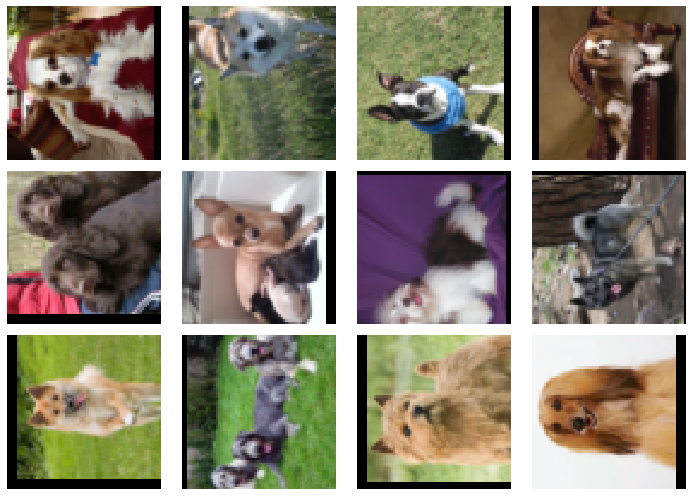

In [33]:
#Data Loaders
batch_size = 4
shuffle = True
num_workers = 2

dataloaders = {}
for s in splits:
    dataloaders[s] = torch.utils.data.DataLoader(
        mydataset[s], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
    )
    
rows = 3
cols = batch_size
fig, axs = plt.subplots(rows, cols, figsize=(10, 7))

for row in range(rows):
    batch = next(iter(dataloaders["train"]))
    images, labels = batch
    for col, image in enumerate(images):
        ax = axs[row, col]
        ax.imshow(image.permute(2, 1, 0))
        ax.axis("off")

plt.tight_layout()

In [ ]:
#Resize images and save to local disk
'''
from tqdm import tqdm
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
resized_path = pathlib.Path("./dogImages_resized")
resized_path.mkdir(exist_ok=True)
for s in splits:
    split_path = resized_path / s
    split_path.mkdir(exist_ok=True)
    for idx, (img_tensor, label) in enumerate(tqdm(mydataset[s])):
        label_path = split_path / f"{label:02}"
        label_path.mkdir(exist_ok=True)
        filename = mydataset[s].imgs[idx][0].split("/")[-1]
        tv.utils.save_image(img_tensor, label_path / filename)
        '''



  0%|          | 0/6680 [00:00<?, ?it/s]

  0%|          | 4/6680 [00:00<03:17, 33.85it/s]

  0%|          | 8/6680 [00:00<03:10, 34.99it/s]

  0%|          | 12/6680 [00:00<03:11, 34.81it/s]

  0%|          | 16/6680 [00:00<03:16, 33.83it/s]

  0%|          | 19/6680 [00:00<03:32, 31.30it/s]

  0%|          | 23/6680 [00:00<03:31, 31.44it/s]

  0%|          | 27/6680 [00:00<03:29, 31.79it/s]

  0%|          | 31/6680 [00:00<03:32, 31.32it/s]

  1%|          | 35/6680 [00:01<03:31, 31.36it/s]

  1%|          | 39/6680 [00:01<03:28, 31.85it/s]

  1%|          | 44/6680 [00:01<03:13, 34.35it/s]

  1%|          | 48/6680 [00:01<03:09, 35.01it/s]

  1%|          | 53/6680 [00:01<02:56, 37.44it/s]

  1%|          | 57/6680 [00:01<03:36, 30.60it/s]

  1%|          | 61/6680 [00:01<03:25, 32.15it/s]

  1%|          | 65/6680 [00:01<03:17, 33.55it/s]

  1%|          | 69/6680 [00:02<03:08, 35.04it/s]

  1%|          | 74/6680 [00:02<02:58, 36.97it/s]

  1%|          | 78/6680 [00:02<02:58, 3

In [7]:
'''
transform = transforms.Compose(
         [
            transforms.Resize(64),
            transforms.RandomCrop(64, padding=4),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ]
    )

dataset = datasets.ImageFolder("./dogImages/test/", transforms.ToTensor(),)
dataset_resized = datasets.ImageFolder("./dogImages_resized/test/", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset_resized, batch_size=1,
       shuffle=False)
print(dataloader.dataset)
#dataset.imgs
'''

Dataset ImageFolder
    Number of datapoints: 837
    Root location: ./dogImages_resized/test/
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               RandomCrop(size=(64, 64), padding=4)
               ToTensor()
           )


In [7]:
#To see before and after image resizing
#fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#image = next(iter(dataset))[0]
#image_resized = next(iter(dataset_resized))[0]

#ax[0].imshow(image.permute(1, 2, 0))
#ax[0].axis("off")
#ax[0].set_title(f"Before - {tuple(image.shape)}")
#ax[1].imshow(image_resized.permute(1, 2, 0))
#ax[1].axis("off")
#ax[1].set_title(f"After - {tuple(image_resized.shape)}")
#plt.tight_layout()

In [7]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/dogImages/train/
!aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/dogImages/valid/
!aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/dogImages/test/

upload: dogImages_resized/train/00/.ipynb_checkpoints/Affenpinscher_00001-checkpoint.jpg to s3://sagemaker-us-east-1-143477605183/s3dogImages_resized/train/00/.ipynb_checkpoints/Affenpinscher_00001-checkpoint.jpg
upload: dogImages_resized/train/00/Affenpinscher_00008.jpg to s3://sagemaker-us-east-1-143477605183/s3dogImages_resized/train/00/Affenpinscher_00008.jpg
upload: dogImages_resized/train/00/Affenpinscher_00007.jpg to s3://sagemaker-us-east-1-143477605183/s3dogImages_resized/train/00/Affenpinscher_00007.jpg
upload: dogImages_resized/train/00/Affenpinscher_00006.jpg to s3://sagemaker-us-east-1-143477605183/s3dogImages_resized/train/00/Affenpinscher_00006.jpg
upload: dogImages_resized/train/00/Affenpinscher_00002.jpg to s3://sagemaker-us-east-1-143477605183/s3dogImages_resized/train/00/Affenpinscher_00002.jpg
upload: dogImages_resized/train/00/Affenpinscher_00009.jpg to s3://sagemaker-us-east-1-143477605183/s3dogImages_resized/train/00/Affenpinscher_00009.jpg
upload: dogImages_resi

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.3),
    "batch_size": CategoricalParameter([16, 32, 64]),
}

objective_metric_name = "Average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]
!set -m
input_uri = 's3://'+bucket+'/dogImages/'

In [6]:
#TODO: Create estimators for your HPs
hyperparameters = {"learning_rate": 0.00125, "batch_size": 16}
 #assigned for testing the training job
estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    entry_point="hpo.py",
    base_job_name="Doghpo",
    framework_version="1.4.0",
    py_version="py3",
    #hyperparameters=hyperparameters,
)

# TODO: Your HP tuner here
principalTuner =  HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [58]:
# test our training job---unnecessary
#import os

#estimator.fit({ "training": input_uri}, wait=True)

In [7]:
# TODO: Fit your HP Tuner
import os

os.environ['SM_CHANNEL_TRAINING']=input_uri
os.environ['SM_MODEL_DIR']=input_uri+'models/'
os.environ['SM_OUTPUT_DATA_DIR']=input_uri+'outputs/'

principalTuner.fit({ "training": input_uri}, wait=True
) # TODO: Remember to include your data channels

........................................................................................................................................................................................................................................................................................................!


In [8]:
# TODO: Get the best estimators and the best HPs
best_estimator = principalTuner.best_estimator()



2022-01-26 04:26:37 Starting - Preparing the instances for training
2022-01-26 04:26:37 Downloading - Downloading input data
2022-01-26 04:26:37 Training - Training image download completed. Training in progress.
2022-01-26 04:26:37 Uploading - Uploading generated training model
2022-01-26 04:26:37 Completed - Training job completed


In [9]:
#Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()
best_hyperparameters

{'_tuning_objective_metric': '"Average test loss"',
 'batch_size': '"64"',
 'learning_rate': '0.0015302323447893022',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"Doghpo-2022-01-26-04-03-43-677"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-143477605183/Doghpo-2022-01-26-04-03-43-677/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [21]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

loss_not_decreasing_rule = Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),
                             rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0",
                                             "mode": "TRAIN"})
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "10"})]
debugger_config=DebuggerHookConfig( collection_configs=collection_configs)


In [22]:
hyperparameters =  {'learning_rate': 0.00153, 'batch_size': 64} #Best of my tuner hyperparameter. 

In [14]:


hyperparameters = {
                   "learning_rate": round(float(best_hyperparameters['learning_rate']), 5),
                   "batch_size":int(best_hyperparameters['batch_size'].replace("\"", "")), 
   }
hyperparameters

{'learning_rate': 0.00153, 'batch_size': 64}

In [23]:
# TODO: Create and fit an estimator
import os
estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge", #ml.g4dn.xlarge, ml.m5.xlarge
    entry_point="train_model.py",
    base_job_name="Dogprofile",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config,
    rules=rules,
) # TODO: Your estimator here

input_uri = 's3://'+bucket+'/dogImages/'
os.environ['SM_CHANNEL_TRAINING']=input_uri
os.environ['SM_MODEL_DIR']=input_uri+'models/'
os.environ['SM_OUTPUT_DATA_DIR']=input_uri+'outputs/'


estimator.fit({ "training": input_uri}, wait=True)

2022-01-26 06:17:51 Starting - Starting the training job...
2022-01-26 06:18:01 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-01-26 06:19:15 Starting - Preparing the instances for training.........
2022-01-26 06:20:47 Downloading - Downloading input data.........
2022-01-26 06:22:20 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-26 06:22:36,663 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-26 06:22:36,667 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-01-26 06:22:36,677 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-26 06:22:39,694 

In [24]:

print(estimator.latest_training_job.name)
print(estimator.model_data)


Dogprofile-2022-01-26-06-17-50-988
s3://sagemaker-us-east-1-143477605183/Dogprofile-2022-01-26-06-17-50-988/output/model.tar.gz


[2022-01-26 06:42:34.673 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
Training jobname: Dogprofile-2022-01-26-06-17-50-988
Region: us-east-1
****** s3://sagemaker-us-east-1-143477605183/Dogprofile-2022-01-26-06-17-50-988/debug-output/CrossEntropyLoss_output_0
[2022-01-26 06:42:34.734 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-143477605183/Dogprofile-2022-01-26-06-17-50-988/debug-output
[2022-01-26 06:42:35.744 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-26 06:42:36.764 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1

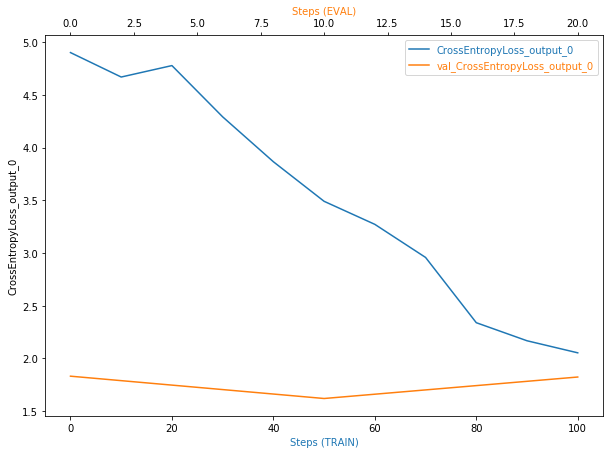

In [25]:
# TODO: Plot a debugging output.
import boto3
from smdebug import modes
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

session_local = boto3.session.Session()
region = session_local.region_name

training_job_name = estimator.latest_training_job.name
#training_job_name = 'debugdog-2022-01-23-12-39-13-511'
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")
print("******", estimator.latest_job_debugger_artifacts_path()+'/CrossEntropyLoss_output_0')
trial = create_trial(estimator.latest_job_debugger_artifacts_path())


print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
plot_tensor(trial, 'CrossEntropyLoss_output_0')


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it? 
It seems that the model is training in a normal way, because the train loss is decreasing and the validation loss is in a good range. Although because the slope of the training loss is sharp and the validation loss is going to be higher at the end of steps, the model may overfit the train dataset but I think we should train the model on some more epochs to be sure about our guess.
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it? 
If the training job loss plot shows that the loss is not decreasing in a normal way and for example the plot goes up and down, I would decreased the learning rate to avoid bouncing the loss. If the train loss goes down continuesly but the validation loss is high and not decreasing, it means that the model is overfitting on the train dataset and the learning rate should be a bigger number to avoid overfitting. So I should change the hyperparameters e.g. I should assign a suitable number to my learning rate to avoid overfitting/underfitting, and to overcome less accurate predictions. Maybe it's a good idea to change the number of batches that my model can be trained better.

In [26]:
# TODO: Display the profiler output
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-143477605183/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-us-east-1-143477605183/Dogprofile-2022-01-26-06-17-50-988/profiler-output


Profiler data from system is available


In [29]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

"""view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)"""

'view_timeline_charts = TimelineCharts(\n    system_metrics_reader,\n    framework_metrics_reader=None,\n    select_dimensions=["CPU", "GPU"],\n    select_events=["total"],\n)'

In [30]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-143477605183/Dogprofile-2022-01-26-06-17-50-988/rule-output


In [31]:
! aws s3 ls {rule_output_path} --recursive

2022-01-26 06:41:22     329711 Dogprofile-2022-01-26-06-17-50-988/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-26 06:41:21     171069 Dogprofile-2022-01-26-06-17-50-988/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-26 06:41:17        192 Dogprofile-2022-01-26-06-17-50-988/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-26 06:41:17        200 Dogprofile-2022-01-26-06-17-50-988/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-26 06:41:17        126 Dogprofile-2022-01-26-06-17-50-988/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-26 06:41:17        127 Dogprofile-2022-01-26-06-17-50-988/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-26 06:41:17        199 Dogprofile-2022-01-26-06-17-50-988/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
2022-01-26 06:41:1

In [32]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-143477605183/Dogprofile-2022-01-26-06-17-50-988/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-143477605183/Dogprofile-2022-01-26-06-17-50-988/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-143477605183/Dogprofile-2022-01-26-06-17-50-988/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-143477605183/Dogprofile-2022-01-26-06-17-50-988/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-143477605183/Dogprofile-2022-01-26-06-17-50-988/rule-ou

In [33]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [35]:
import IPython

#IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [38]:
model_location=estimator.model_data
#model_location = 's3://sagemaker-us-east-1-143477605183/Dogprofile-2022-01-26-06-17-50-988/output/model.tar.gz'
model_location

's3://sagemaker-us-east-1-143477605183/Dogprofile-2022-01-26-06-17-50-988/output/model.tar.gz'

In [78]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [79]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [41]:

pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4.0',
                             predictor_cls=ImagePredictor) 

In [42]:
# TODO: Deploy your model to an endpoint

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge') # TODO: Add your deployment configuration like instance type and number of instances

-----!

In [80]:
from PIL import Image
import io
import torch
import numpy as np
import json
import requests

In [81]:
#create predictor from an endpoint

endpoint = 'pytorch-inference-2022-01-26-06-53-04-599'
predictor = sagemaker.predictor.Predictor(endpoint, sagemaker_session=session) 


In [82]:
with open("./dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg", "rb") as f:
    payload = f.read()
    
type(payload)

bytes

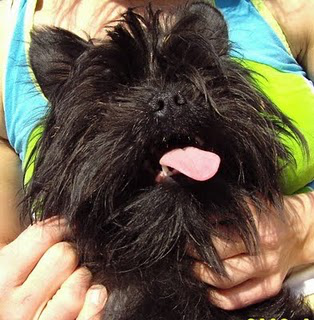

In [83]:
Image.open(io.BytesIO(payload))

In [84]:
#getting predictions from the endpoint

response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
def prediction_class(response):
    prediction = json.loads(response.decode('utf-8'))
    num_of_classes = len(prediction[0])
    highest_probability_index= np.argmax(prediction, 1)
    predicted_class = (highest_probability_index+1)[0]
    return(predicted_class)

print("Our predictor says the image is in the class No.",prediction_class(response))

Our predictor says the image is in the class No. 1


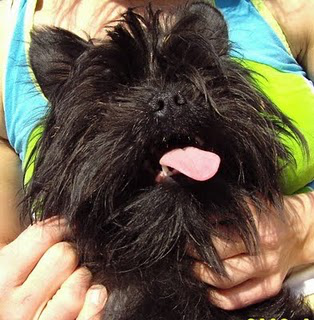

In [85]:
#get prediction from the url of an image

request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
#request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
#type(img_bytes)

Image.open(io.BytesIO(payload))

In [86]:
#getting response of the predictor
response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
print("Our predictor says the image is in the class No.",prediction_class(response))

Our predictor says the image is in the class No. 1


In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()